# Question 1

Using the calibration from Section 2.6, write a Python function named
feasible() that has the following form:

b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)

Use the following parameterization of the model for the problems below. Because agents live for only three periods, assume that each period of life is 20 years. If the annual discount factor is estimated to be 0.96, then the 20-year discount factor is β = 0.9620 = 0.442. Let the annual depreciation rate of capital be 0.05. Then the 20-year depreciation rate is δ = 1 − (1 − 0.05)20 = 0.6415. Let the coefficient of relative risk aversion be σ = 3, let the productivity scale parameter of firms be A = 1, and let the capital share of income be α = 0.35.

In [343]:
import numpy as np
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [331]:
# globals
A = 1
alpha = 0.35
delta = 0.6415
beta = 0.442
sigma = 3
SS_tol = 1e-5

labor_supply = np.array([1.0, 1.0, 0.2])

f_params = (labor_supply, A, alpha, delta)
bvec_guess = np.array([0, 1, 1])

params = ((beta, sigma, labor_supply, A, alpha, delta, SS_tol))

In [332]:
def find_r(L, K, alpha=alpha, A=A, delta=delta):
    """
    Finds the interest rate given paramters
    """
    r = (alpha * A * ((L / K) ** (1 - alpha))) - delta
    return r

def find_w(L, K, alpha=alpha, A=A):
    """
    Finds the wage given paramters
    """    
    w = (1 - alpha) * A * ((K / L) ** alpha) 
    return w

def production(K,L, A=A, alpha=alpha):
    """
    Cobb-Douglas production function
    """
    Y = A * (K ** alpha) * (L ** (1-alpha)) # production
    return Y


In [333]:
def feasible(f_params=f_params, bvec_guess=bvec_guess):
    """
    Takes in parameters/guess and spits out Boolean vectors of satisfying constraints.
    Checks the budget constraint, True means violated
    ----------------------------
    Arguments:
    f_params , tuple = (labor_supply, A, alpha, delta)
    bvec_guess, tuple = np.array([scalar, scalar])
    
    Returns:
    b_cnstr, vector = boolean of failing saving constraint
    c_cnstr, vector = boolean of failing consumption constraint
    K_cnstr, vector = boolean of failing capital constraint
    ----------------------------
    """
    # Unpack
    b_1, b_2, b_3 = bvec_guess
    labor_supply, A, alpha, delta = f_params
    
    # Firm Objects
    K = b_1 + b_2 + b_3      # capital
    L = labor_supply.sum()   # labor
    I = delta*K              # Investment
    Y = production(K=K, L=L, A=A, alpha=alpha) # production
    
    # Prices
    r = find_r(L=L, K=K) #interest
    w = find_w(L=L, K=K) # wage

    # HH's problem
    wages = w * labor_supply
    savings = np.array([b_1, b_2, b_3])
    sav_tomorrow = np.roll(savings, len(savings)-1)
    
    # Capital constraint
    K_cnstr = True if K <=0 else False
        
    # consumtion constraint
    cons = (1 + r) * savings + wages - sav_tomorrow
    c_cnstr = (cons <= 0)
    
    # savings constraint
    if c_cnstr[1]:
        b_cnstr = np.array([True, True])
    else:
        b_cnstr = np.array([c_cnstr[0], c_cnstr[-1]])

    return b_cnstr, c_cnstr, K_cnstr
#b_cnstr, c_cnstr, K_cnstr

## Part a

In [334]:
bvec_guess = np.array([0, 1.0, 1.2])
b_cnstr, c_cnstr, K_cnstr = feasible(bvec_guess=bvec_guess)
print('b_cnstr is ', b_cnstr, '\nc_cnstr is ', c_cnstr,'\nK_cnstr is ', K_cnstr)
print('\nConsumption nonnegativity for s=1 is violated')

b_cnstr is  [ True False] 
c_cnstr is  [ True False False] 
K_cnstr is  False

Consumption nonnegativity for s=1 is violated


## Part b

In [335]:
bvec_guess = np.array([0, 0.06, -0.001])
b_cnstr, c_cnstr, K_cnstr = feasible(bvec_guess=bvec_guess)
print('b_cnstr is ', b_cnstr, '\nc_cnstr is ', c_cnstr,'\nK_cnstr is ', K_cnstr)
print('\nNo constraint is violated but the household is borrowing from age 3 to consume at age 2 which is weird.')

b_cnstr is  [False False] 
c_cnstr is  [False False False] 
K_cnstr is  False

No constraint is violated but the household is borrowing from age 3 to consume at age 2 which is weird.


## Part c

In [336]:
bvec_guess = np.array([0, 0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = feasible(bvec_guess=bvec_guess)
print('b_cnstr is ', b_cnstr, '\nc_cnstr is ', c_cnstr,'\nK_cnstr is ', K_cnstr)
print('\nNo constraint is violated.')

b_cnstr is  [False False] 
c_cnstr is  [False False False] 
K_cnstr is  False

No constraint is violated.


# Question 2

In [425]:
def u_prime(c, sigma=sigma):
    """
    CRRRA marginal utility with parameter sigma
    """
    if c == 0:
        return np.inf
    else:
        return c ** (-sigma)

def ee_errors(bvec_guess, *args):
    """
    Compute vector (s-1 x 1) euler equation error
    """
    
    beta, sigma, labor_supply, A, alpha, delta, SS_tol = args
    
    # Impose firm optimality
    K = bvec_guess.sum()
    L = labor_supply.sum()
    
    # get prices
    r = find_r(L, K, alpha=alpha, A=A, delta=delta)
    w = find_w(L, K, alpha=alpha, A=A)
    
    # HH's problem
    wages = w * labor_supply
    savings = np.array([0, *bvec_guess])
    sav_tomorrow = np.roll(savings, len(savings)-1)
    cons = (1 + r) * savings + wages - sav_tomorrow
    
    EulErr_ss = np.array([
        beta * (1+r) * u_prime(cons[1]) - u_prime(cons[0]),
        beta * (1+r) * u_prime(cons[2]) - u_prime(cons[1])
    ])
    
    return EulErr_ss

def get_SS(params=params, bvec_guess=bvec_guess, SS_graphs=False):
    start_time = time.clock()
    
    # unpack
    beta, sigma, labor_supply, A, alpha, delta, SS_tol = params
    
    # find SS
    results = opt.root(ee_errors, bvec_guess[1:], args=params)
    
    b_ss = np.array([*results.x, 0])
    EulErr_ss = results.fun
    
    K_ss = b_ss.sum()
    L_ss = labor_supply.sum()
    Y_ss = production(K_ss, L_ss, A=A, alpha=alpha)
    
    r_ss = find_r(L_ss, K_ss, alpha=alpha, A=A, delta=delta)
    w_ss = find_w(L_ss, K_ss, alpha=alpha, A=A)
    
    asset_income = np.roll(b_ss, 1) # rotates vector from savings decision to assett income
    c_ss = ((1 + r_ss) * asset_income) + (w_ss * labor_supply) - b_ss
    C_ss = c_ss.sum()

    RCerr_ss = Y_ss - C_ss - delta*K_ss  # resource constraint error
    
    ss_time = time.clock() - start_time  #timing
    
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    
    if SS_graphs:
        fig, axes = plt.subplots(2,1,figsize=(10,6))
        axes[0].plot(c_ss, 'r-o')
        axes[0].set_title('Steady state consumption')
        axes[0].set_xlabel('Age')
        axes[0].set_ylabel('Consumption')
        
        axes[1].plot(b_ss, 'b-o')
        axes[1].set_title('Steady state savings')
        axes[1].set_xlabel('Age')
        axes[1].set_ylabel('Savings')
        [ax.set_xticks([0,1,2]) for ax in axes]
        
        plt.tight_layout()
    return ss_output

why is consumption highest in retirement?


{'b_ss': array([0.01931253, 0.0584111 , 0.        ]),
 'c_ss': array([0.18241213, 0.20961468, 0.24087387]),
 'w_ss': 0.20172465739052575,
 'r_ss': 2.433062339127069,
 'K_ss': 0.07772362575316386,
 'Y_ss': 0.6827603788602411,
 'C_ss': 0.6329006729395864,
 'EulErr_ss': array([ 1.39266376e-12, -2.62900812e-12]),
 'RCerr_ss': 8.326672684688674e-17,
 'ss_time': 0.006033999999999651}

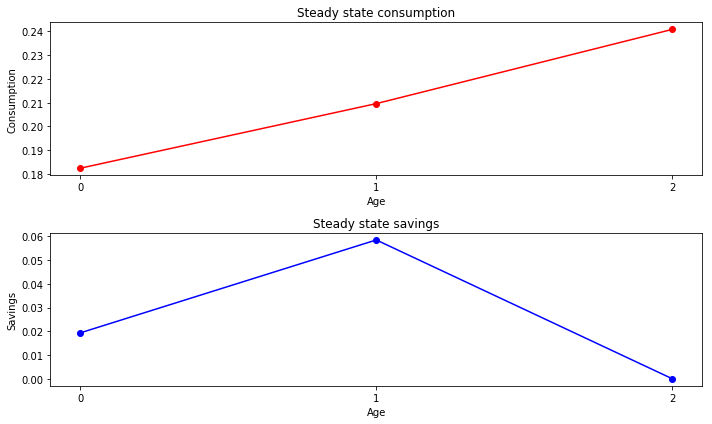

In [429]:
print('why is consumption highest in retirement?')
get_SS(SS_graphs=True)

## part c

If beta goes up, then 

b_1 and b_2 go up, this makes sense because now the marginal benefit of saving more has gone up

c_1, c_2, and c_3 go up. This is surprising but can be rationalized by the fact that w went up because f'(L) goes up in K=sum(b).

w_ss has gone up because more saving means MPL is higher
r_ss has gone down because more saving means marginal product of capital is lower.


{'b_ss': array([0.02817692, 0.07686545, 0.        ]),
 'c_ss': array([0.19597528, 0.22861594, 0.26669307]),
 'w_ss': 0.22415219593446706,
 'r_ss': 1.8863765057189819,
 'K_ss': 0.1050423702259807,
 'Y_ss': 0.7586689708551193,
 'C_ss': 0.6912842903551526,
 'EulErr_ss': array([-6.87805368e-12, -2.52953214e-12]),
 'RCerr_ss': 9.71445146547012e-17,
 'ss_time': 0.0028639999999988675}

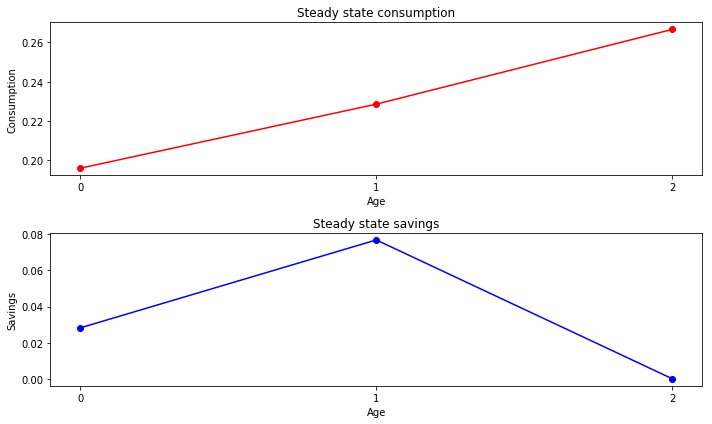

In [432]:
# increase beta, compartive statics
new_beta = 0.55
params1 = ((new_beta, sigma, labor_supply, A, alpha, delta, SS_tol))
get_SS(params = params1, SS_graphs=True)